# Data Analysis for UK SDG 11.2.1 

In [1]:
# %load_ext pycodestyle_magic
# %pycodestyle_off

In [13]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from math import cos
from modules import geo_df_from_csv, geo_df_from_geospatialfile, find_points_in_poly, draw_5km_buffer, get_and_save_geo_dataset, dl_csv_make_df

In [14]:
#get current working directory 
cwd = os.getcwd()

# define data directory
data_dir = (os.path.join
            (cwd,
             'data'))


In [15]:
zip_link = "http://naptan.app.dft.gov.uk/DataRequest/Naptan.ashx?format=csv"
zip_name = "Napatan.zip"
zip_path = os.path.join(data_dir, zip_name)
csv_nm = 'Stops.csv'
csv_path = os.path.join(data_dir, csv_nm)

_ = dl_csv_make_df(csv_nm,
    csv_path,
    zip_name,
    zip_path,
    zip_link,
    data_dir)

Dowloading file from http://naptan.app.dft.gov.uk/DataRequest/Naptan.ashx?format=csv
Saving to /home/james/programming/SDG_11.2.1/data/Napatan.zip
Unzipping Napatan.zip. Extracting Stops.csv


In [18]:
# TODO: make geo_df_from_csv accept cols argument as the csv is large
# Create the geo dataframe with the stops data
cols =['NaptanCode', 'CommonName','Easting', 'Northing']

stops_geo_df = (geo_df_from_csv(path_to_csv=csv_path,
                            delim=',',
                            geom_x='Easting', # change to eastings and northings
                            geom_y='Northing',
                            cols=cols))

Index(['NaptanCode', 'CommonName', 'Easting', 'Northing'], dtype='object')


In [23]:
# Getting the Lower Super Output Area for the UK into a dataframe
uk_LSOA_shp_file = "Lower_Layer_Super_Output_Areas__December_2011__Boundaries_EW_BGC.shp"
full_path = os.path.join(os.getcwd(), "data", "LSOA_shp", uk_LSOA_shp_file)
uk_LSOA_df = geo_df_from_geospatialfile(path_to_file=full_path)

In [24]:
uk_LSOA_df.head()

,FID,LSOA11CD,LSOA11NM,LSOA11NMW,Age_Indica,Shape__Are,Shape__Len,geometry
0,1,E01001019,Croydon 044B,Croydon 044B,0,1.515854e+06,8362.659636,"POLYGON ((530587.304 158905.439, 530600.686 15..."
1,2,E01000001,City of London 001A,City of London 001A,0,3.439074e+05,3682.439418,"POLYGON ((532105.104 182011.233, 532162.503 18..."
2,3,E01001020,Croydon 044C,Croydon 044C,0,9.354317e+05,7236.272525,"POLYGON ((530958.372 158290.140, 531018.013 15..."
3,4,E01001021,Croydon 044D,Croydon 044D,0,5.237812e+06,12160.534720,"POLYGON ((530583.015 158101.164, 530786.013 15..."
4,5,E01000002,City of London 001B,City of London 001B,0,5.834740e+05,3910.387238,"POLYGON ((532746.826 181786.894, 532671.701 18..."


In [9]:
# geo_df_from_geospatialfile(os.path.join
#                            (os.getcwd(),
#                             'data',
#                             'birmingham_geo_dataset.json'))

# # Manipulating the Birmingham df
# # splitting the "codes" column into "gss" and "unit_id"
# # setting "id" as the index
    
# birmingham_df = pd.DataFrame.from_dict(birmingahm_gsscode_dataset).T
# gss_code_cols = pd.DataFrame.from_dict(birmingahm_gsscode_dataset).T.codes.apply(pd.Series).drop("ons", axis=1) 
# birmingham_df = birmingham_df.join(gss_code_cols).drop(["codes", "all_names"], axis=1) 
# birmingham_df.set_index('id', inplace=True)

In [22]:
birmingham_df.sample(10)

NameError: name 'birmingham_df' is not defined

In [11]:
uk_LSOA_df.head()

,FID,LSOA11CD,LSOA11NM,LSOA11NMW,Age_Indica,Shape__Are,Shape__Len,geometry
0,1,E01001019,Croydon 044B,Croydon 044B,0,1.515854e+06,8362.659636,"POLYGON ((530587.304 158905.439, 530600.686 15..."
1,2,E01000001,City of London 001A,City of London 001A,0,3.439074e+05,3682.439418,"POLYGON ((532105.104 182011.233, 532162.503 18..."
2,3,E01001020,Croydon 044C,Croydon 044C,0,9.354317e+05,7236.272525,"POLYGON ((530958.372 158290.140, 531018.013 15..."
3,4,E01001021,Croydon 044D,Croydon 044D,0,5.237812e+06,12160.534720,"POLYGON ((530583.015 158101.164, 530786.013 15..."
4,5,E01000002,City of London 001B,City of London 001B,0,5.834740e+05,3910.387238,"POLYGON ((532746.826 181786.894, 532671.701 18..."


In [11]:
def get_polygons_of_loccode(geo_df, loc_code='OA11CD', search=None):
    """
    Gets the polygon for a place based on it name, LSOA code or OA code
    
    Parameters:
    geo_df: (gpd.Datafame):
    loc_code = LSOA11CD, OA11CD or LSOA11NM
    search = search terms to find in the LSOA11NM column. Only needed if intending
        to dissolve on a name in the LSOA11NM column
    Returns: (gpd.DataFrame) agregated multipolygons, agregated on LSOA, OA code, or a search
        in the LSOA11NM column
    """
    if loc_code in ['LSOA11CD', 'OA11CD']:
        polygons = geo_df.dissolve(by=loc_code)
    else:
        filtered_df = geo_df[geo_df.LSOA11NM.str.contains(search)]
        filtered_df.insert(0, 'place_name', search)
        polygons = filtered_df.dissolve(by='place_name')
        #TODO: need to filter out other un-needed columns only geometry and place_name is need
    return polygons

just_birmingham_LSOA = (get_polygons_of_loccode(geo_df=uk_LSOA_df, loc_code='LSOA11NM', search="Birmingham"))

In [12]:
just_birmingham_LSOA.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°45'N to 61°N, 9°W to 2°E
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [16]:
# Creating Birmingham polygon

just_birmingham_geom = just_birmingham_LSOA.drop(["FID","LSOA11CD","LSOA11NMW","Age_Indica", "Shape__Are","Shape__Len","LSOA11NM"], axis=1)
# just_birmingham_geom = just_birmingham_LSOA.pop('geometry')

just_birmingham_geom['city'] = "birmingham"
# just_birmingham_geom['new_column'] = 0
just_birmingham_geom = just_birmingham_geom.dissolve(by='city')
just_birmingham_geom

,geometry
city,
birmingham,"POLYGON ((405940.897 278844.452, 405969.012 27..."


In [21]:
# Creating a Geo Dataframe of only stops in Birmingham
import ipdb; ipdb.set_trace()
birmingham_stops_geo_df = (find_points_in_poly
                       (geo_df=stops_geo_df,
                        polygon_obj=just_birmingham_geom))

--Return--
None
> <ipython-input-21-0f933b36fa97>(2)<module>()
      1 # Creating a Geo Dataframe of only stops in Birmingham
----> 2 import ipdb; ipdb.set_trace()
      3 birmingham_stops_geo_df = (find_points_in_poly

ipdb> exit


BdbQuit: 

In [20]:
just_birmingham_geom.crs == stops_geo_df.crs

True

In [17]:
birmingham_stops_geo_df.sample(10)

ValueError: a must be greater than 0 unless no samples are taken

In [79]:
# Getting the west midlands population
Wmids_pop_df = pd.read_csv(os.path.join
                           (data_dir,
                            'population_estimates',
                            'westmids_pop_only.csv'))

Wmids_pop_df.shape
wmids_before = Wmids_pop_df.columns

/home/james/anaconda3/envs/SDG_11.2.1/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [80]:
# Get population weighted centroids into a dataframe
uk_pop_wtd_centr_df = (geo_df_from_geospatialfile
                       (os.path.join
                        (data_dir,
                         'pop_weighted_centroids')))

In [81]:
# Understanding was the OA11CD codes look like by taking a sample. 
uk_pop_wtd_centr_df.OA11CD.sample(10)

4684      E00064909
147332    E00001312
140250    E00054284
148342    E00001605
138233    E00052056
139477    E00054601
146261    E00060176
121144    E00035708
84076     E00137704
74602     E00128515
Name: OA11CD, dtype: object

In [82]:
# Joining the population dataframe to the centroids dataframe
Wmids_pop_df =Wmids_pop_df.join(other=uk_pop_wtd_centr_df.set_index('OA11CD'), on='OA11CD', how='left')

In [83]:
# This is the dataframe with the population and the centroids
Wmids_pop_df.head(20)

,OA11CD,LSOA11CD,All Ages,0,1,2,3,4,5,6,...,83,84,85,86,87,88,89,90+,OBJECTID,geometry
0,E00045110,E01008881,293,1,3,2,2,4,7,4,...,0,4,4,2,2,3,0,2,131601,POINT (-1.81206 52.46968)
1,E00045113,E01008881,357,5,4,8,5,0,6,6,...,0,1,0,1,0,1,0,1,131597,POINT (-1.81795 52.46915)
2,E00045116,E01008881,411,10,4,5,9,10,6,13,...,0,0,1,2,3,1,0,2,131578,POINT (-1.81646 52.46774)
3,E00045118,E01008881,395,3,7,2,4,7,2,6,...,2,2,1,3,5,2,4,1,131609,POINT (-1.81240 52.46833)
4,E00045123,E01008881,277,4,3,7,4,4,7,5,...,3,1,0,0,2,2,0,5,132808,POINT (-1.81005 52.46542)
5,E00045114,E01008882,324,4,0,5,6,2,9,5,...,3,0,3,0,0,0,1,1,131586,POINT (-1.82466 52.46745)
6,E00045119,E01008882,422,8,8,11,8,9,8,10,...,0,2,1,0,3,0,3,0,131611,POINT (-1.82728 52.46671)
7,E00045120,E01008882,368,9,8,5,7,5,4,6,...,1,1,1,0,4,0,0,0,132810,POINT (-1.83021 52.46600)
8,E00045121,E01008882,339,9,5,12,3,7,4,6,...,1,2,0,0,2,0,0,1,132812,POINT (-1.82538 52.46614)
9,E00045124,E01008882,376,5,9,5,13,9,4,6,...,2,0,1,1,0,1,0,0,132802,POINT (-1.83236 52.46573)


In [23]:
Wmids_pop_df.shape

(17916, 96)

In [24]:
bham_LSOA_df = uk_LSOA_df[uk_LSOA_df.LSOA11NM.str.contains("Birmingham")]

In [25]:
bham_clean = bham_LSOA_df[['LSOA11CD','LSOA11NM']]

In [26]:
# merge the two dataframes limiting to just Birmingham

bham_pop_df = Wmids_pop_df.merge(bham_clean, how='right', left_on='LSOA11CD', right_on='LSOA11CD')



In [27]:
bham_pop_df.head()

,OA11CD,LSOA11CD,All Ages,0,1,2,3,4,5,6,...,84,85,86,87,88,89,90+,OBJECTID,geometry,LSOA11NM
0,E00046134,E01009100,320,1,4,4,1,3,5,2,...,1,2,1,1,2,1,5,133250,POINT (-1.81546 52.52001),Birmingham 025D
1,E00046136,E01009100,358,4,4,2,6,7,8,5,...,3,0,4,0,1,2,4,133246,POINT (-1.81418 52.51789),Birmingham 025D
2,E00046145,E01009100,201,1,1,2,3,1,4,1,...,1,0,1,0,0,0,2,131136,POINT (-1.81578 52.52586),Birmingham 025D
3,E00046184,E01009100,335,7,1,3,5,6,3,2,...,2,4,2,3,3,2,14,132183,POINT (-1.81406 52.52726),Birmingham 025D
4,E00175609,E01009100,244,5,3,4,1,6,5,6,...,0,0,1,1,0,0,2,133854,POINT (-1.81467 52.52434),Birmingham 025D


In [28]:
bham_pop_df.LSOA11CD.nunique()

639

In [29]:
bham_LSOA_df.LSOA11CD.nunique()

639

In [30]:
Wmids_pop_df.OA11CD.nunique()

17916

In [31]:
bham_pop_df.OA11CD.nunique()

3223

In [45]:
# find which stops are in birmingham
bham_stops = find_points_in_poly(geo_df=stops_geo_df, polygon_obj=just_birmingham_geom)


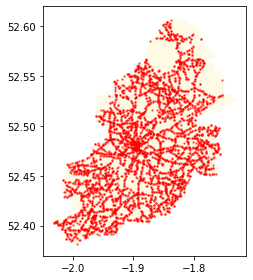

In [62]:
# Get all the stops in Birmingham on to a map of Birmingham
fig, ax = plt.subplots()
_ = just_birmingham_geom.plot(ax=ax, color='gold', markersize=2, alpha=0.1)
_ = bham_stops.plot(ax=ax, color='red', markersize=2, alpha=0.5)

plt.tight_layout()

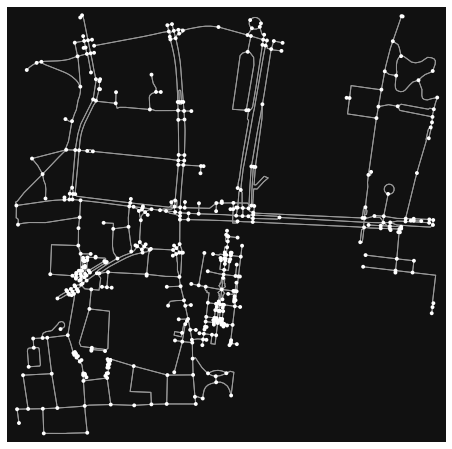

<Figure size 432x288 with 0 Axes>